In [ ]:
# Install Pyro in Google Colab
!pip install pyro-ppl torch pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Import Libraries
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
# --- Generate synthetic bimodal data ---
def generate_bimodal_data(n_points=500, noise_std=0.1, seed=42):
    np.random.seed(seed)
    X = np.random.uniform(-4, 4, size=(n_points, 1))
    y = []
    for x in X:
        if np.random.rand() < 0.5:
            y_val = np.sin(x) + np.random.normal(0, noise_std)
        else:
            y_val = -np.sin(x) + np.random.normal(0, noise_std)
        y.append(y_val)
    y = np.array(y).reshape(-1, 1)
    return X.astype("float32"), y.astype("float32")



In [ ]:
X, y = generate_bimodal_data()

# --- Split into train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).squeeze()
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).squeeze()

input_dim = X_train.shape[1]



In [ ]:
# --- Bayesian Linear Regression Model ---
def regression_model(X, y=None):
    w = pyro.sample("w", dist.Normal(torch.zeros(input_dim), torch.ones(input_dim)))
    b = pyro.sample("b", dist.Normal(0., 1.))
    sigma = 0.1  # fixed noise

    mean = (X @ w.unsqueeze(-1)).squeeze(-1) + b

    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)



In [ ]:
# --- Guide ---
def regression_guide(X, y=None):
    w_loc = pyro.param("w_loc", torch.zeros(input_dim))
    w_scale = pyro.param("w_scale", torch.ones(input_dim), constraint=dist.constraints.positive)
    b_loc = pyro.param("b_loc", torch.tensor(0.0))
    b_scale = pyro.param("b_scale", torch.tensor(1.0), constraint=dist.constraints.positive)

    pyro.sample("w", dist.Normal(w_loc, w_scale))
    pyro.sample("b", dist.Normal(b_loc, b_scale))

In [ ]:
# --- SVI Setup ---
pyro.clear_param_store()
optimizer = Adam({"lr": 0.01})
svi = SVI(regression_model, regression_guide, optimizer, loss=Trace_ELBO())
# --- Training ---
epochs = 2000
for epoch in range(epochs):
    loss = svi.step(X_train, y_train)
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")



Epoch 0: Loss = 65625.7188
Epoch 200: Loss = 21678.9581
Epoch 400: Loss = 15182.4100
Epoch 600: Loss = 16040.2975
Epoch 800: Loss = 11466.9962
Epoch 1000: Loss = 10325.3493
Epoch 1200: Loss = 9665.5959
Epoch 1400: Loss = 10127.1460
Epoch 1600: Loss = 8228.6252
Epoch 1800: Loss = 8497.2587


In [ ]:
# --- Point Estimate Prediction ---
w_map = pyro.param("w_loc").detach()
b_map = pyro.param("b_loc").item()
mean_preds = (X_test @ w_map.unsqueeze(-1)).squeeze() + b_map

rmse = np.sqrt(np.mean((y_test.numpy() - mean_preds.numpy())**2))

print(f"\n📈 RMSE (MAP estimate): {rmse:.4f}")

# --- Uncertainty-Aware Prediction ---
def predict_with_uncertainty(X, T=100):
    predictive = Predictive(regression_model, guide=regression_guide, num_samples=T, return_sites=("w", "b"))
    samples = predictive(X)
    preds = []
    for i in range(T):
        w = samples["w"][i]
        b = samples["b"][i]
        mean = (X @ w.unsqueeze(-1)).squeeze() + b
        preds.append(mean)
    preds = torch.stack(preds)  # shape: (T, N)
    return preds.mean(0), preds.std(0)

mean_pred, std_pred = predict_with_uncertainty(X_test, T=100)



📈 RMSE (MAP estimate): 0.7119


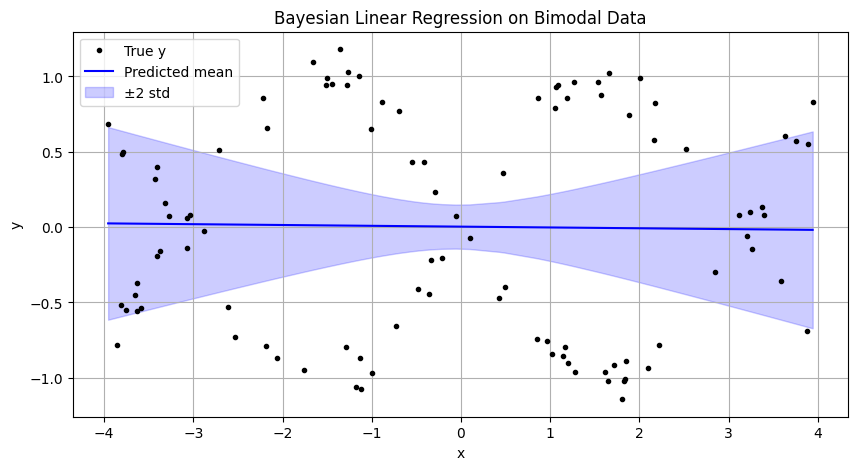

In [ ]:
# --- Plot with Uncertainty ---
x_np = X_test.numpy().flatten()
y_np = y_test.numpy()
mean_np = mean_pred.detach().numpy()
std_np = std_pred.detach().numpy()
sorted_idx = np.argsort(x_np)

plt.figure(figsize=(10, 5))
plt.plot(x_np[sorted_idx], y_np[sorted_idx], 'k.', label="True y")
plt.plot(x_np[sorted_idx], mean_np[sorted_idx], 'b-', label="Predicted mean")
plt.fill_between(
    x_np[sorted_idx],
    mean_np[sorted_idx] - 2 * std_np[sorted_idx],
    mean_np[sorted_idx] + 2 * std_np[sorted_idx],
    color="blue", alpha=0.2, label="±2 std"
)
plt.title("Bayesian Linear Regression on Bimodal Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()